# **Initialization**

In [ ]:
import os
import random
import shutil
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is enabled and available!")
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available. Please check runtime settings.")


GPU is enabled and available!
Device Name: Tesla P100-PCIE-16GB


# **DenseNet121**

## **Import Libraries and Set Random Seeds**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
from skimage import morphology, measure

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Define Dataset Paths and Parameters**

In [ ]:
# Dataset paths
BASE_DIR = '/content/drive/My Drive/AIROP/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

**Vessel Segmentation and overlay**

Preprocessing training images...


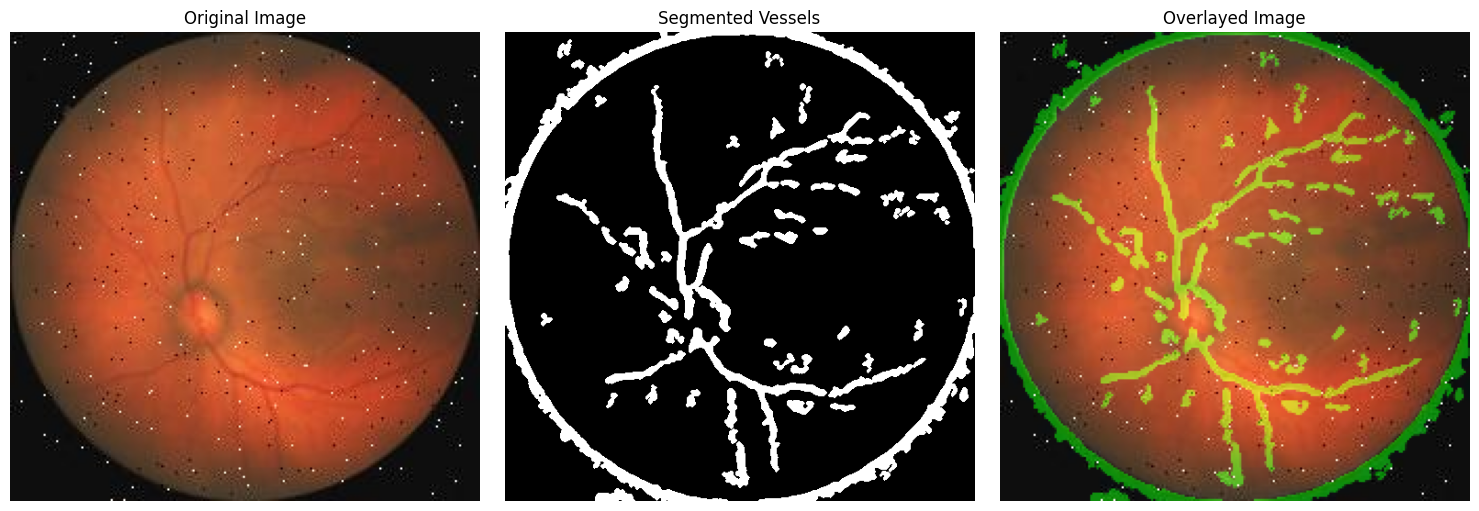

Preprocessing validation images...
Preprocessing test images...


In [ ]:
# Vessel Segmentation Functions
def resize_image(image, size=(512, 512)):
    return cv2.resize(image, size)

def extract_green_channel(image):
    return image[:, :, 1]

def apply_clahe(image, clip_limit=1.5, tile_grid_size=(1, 1)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

def invert_image(image):
    return cv2.bitwise_not(image)

def apply_adaptive_threshold(image, block_size=25, C=6):
    thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    return invert_image(thresholded_image)

def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def morphology_opening(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphology_dilate(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(image, kernel)

def remove_small_objects(image, min_size=500):
    labels = measure.label(image)
    cleaned = morphology.remove_small_objects(labels, min_size=min_size)
    cleaned = (cleaned > 0).astype(np.uint8) * 255
    return cleaned

def vessel_segmentation(image):
    resized_image = resize_image(image)
    green_channel = extract_green_channel(resized_image)
    enhanced_image = apply_clahe(green_channel)
    adaptive_thresh_image = apply_adaptive_threshold(enhanced_image)
    median_filtered_image = apply_median_filter(adaptive_thresh_image)
    opened_image = morphology_opening(median_filtered_image, kernel_size=2)
    dilated_image = morphology_dilate(opened_image, kernel_size=3)
    final_image = remove_small_objects(dilated_image, min_size=100)
    return final_image

def overlay_segmentation(original_image, segmented_image):
    # Resize the segmented image to match the original image's dimensions
    segmented_image_resized = cv2.resize(segmented_image, (original_image.shape[1], original_image.shape[0]))

    # Convert the segmented image to a 3-channel mask
    mask = cv2.cvtColor(segmented_image_resized, cv2.COLOR_GRAY2BGR)

    # Apply a green overlay
    mask = cv2.bitwise_and(mask, np.array([0, 255, 0], dtype=np.uint8))  # Green overlay

    # Overlay the mask on the original image
    overlayed_image = cv2.addWeighted(original_image, 1, mask, 0.5, 0)
    return overlayed_image

# Function to preprocess images with vessel segmentation overlay
def preprocess_images(image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Traverse subdirectories (e.g., Healthy, ROP, RD)
    for class_name in os.listdir(image_dir):
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip if it's not a directory

        # Create corresponding output subdirectory
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        # Process each image in the subdirectory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Unable to read image {image_path}. Skipping.")
                continue  # Skip if the image is not valid

            # Apply vessel segmentation
            segmented_image = vessel_segmentation(original_image)

            # Overlay segmentation on the original image
            overlayed_image = overlay_segmentation(original_image, segmented_image)

            # Resize to the required input size for the model
            overlayed_image = cv2.resize(overlayed_image, (IMG_SIZE, IMG_SIZE))

            # Save the preprocessed image
            output_path = os.path.join(output_class_dir, image_name)
            cv2.imwrite(output_path, overlayed_image)

            # Plot the first image for visualization
            if not hasattr(preprocess_images, 'plot_done'):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(segmented_image, cmap='gray')
                plt.title("Segmented Vessels")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
                plt.title("Overlayed Image")
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                preprocess_images.plot_done = True  # Ensure plotting is done only once

# Preprocess training, validation, and test images
print("Preprocessing training images...")
preprocess_images(TRAIN_DIR, os.path.join(BASE_DIR, 'train_processed'))

print("Preprocessing validation images...")
preprocess_images(VALID_DIR, os.path.join(BASE_DIR, 'valid_processed'))

print("Preprocessing test images...")
preprocess_images(TEST_DIR, os.path.join(BASE_DIR, 'test_processed'))

# Update dataset paths to processed images
TRAIN_DIR_PROCESSED = os.path.join(BASE_DIR, 'train_processed')
VALID_DIR_PROCESSED = os.path.join(BASE_DIR, 'valid_processed')
TEST_DIR_PROCESSED = os.path.join(BASE_DIR, 'test_processed')

## **Data Preprocessing and Augmentation**

In [ ]:
# Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Build and Compile the Model**

In [ ]:
# Load DenseNet-121 base model
densenet_base = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    densenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 6,956,931 (26.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

## **Set Up Model Checkpoints**

In [ ]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

## **Train the Model**

In [ ]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7545 - auc: 0.8836 - loss: 0.7156 - precision: 0.7631 - recall: 0.7428
Epoch 1: val_loss improved from inf to 1.54747, saving model to best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.7552 - auc: 0.8841 - loss: 0.7136 - precision: 0.7638 - recall: 0.7435 - val_accuracy: 0.7140 - val_auc: 0.8380 - val_loss: 1.5475 - val_precision: 0.7148 - val_recall: 0.7122
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.8919 - auc: 0.9700 - loss: 0.3262 - precision: 0.8942 - recall: 0.8900
Epoch 2: val_loss improved from 1.54747 to 0.36285, saving model to best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 89s 722ms/step - accuracy: 0.8920 - auc: 0.9701 - loss: 0.3260 - precision: 0.8942 - recall: 0.8901 - val_accuracy: 0.8925 - val_auc: 0.9751 - val_loss: 0.3628 - val_precision: 0.8989 - val_recall: 0.8907
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.9181 - auc: 0.9830 - loss

## **Plot Training History**

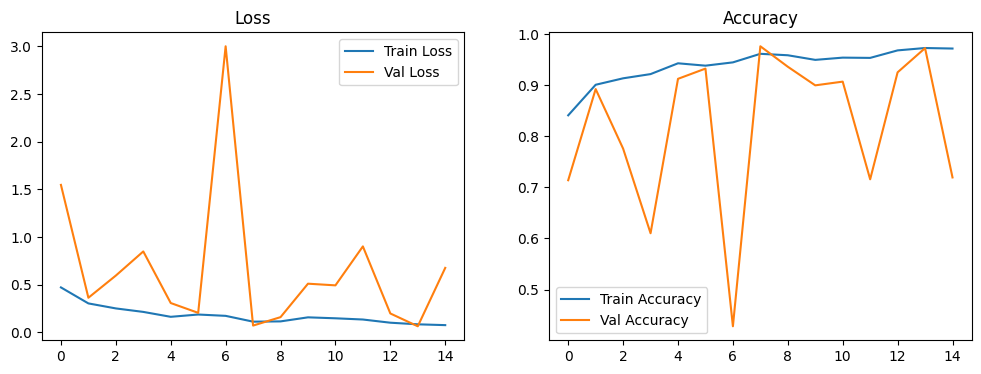

In [ ]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate the Model on Test Data**

In [ ]:
# Evaluate on Test Data
model.load_weights('best_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9283 - auc: 0.9938 - loss: 0.1333 - precision: 0.9283 - recall: 0.9283
Test Loss: 0.0858
Test Accuracy: 0.9491
Test Precision: 0.9491
Test Recall: 0.9491
Test AUC: 0.9980


## **Generate Classification Report and Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.33      0.50         3
          RD       0.92      0.94      0.93        82
         ROP       0.96      0.96      0.96       190

    accuracy                           0.95       275
   macro avg       0.96      0.75      0.80       275
weighted avg       0.95      0.95      0.95       275


Confusion Matrix:
[[  1   0   2]
 [  0  77   5]
 [  0   7 183]]


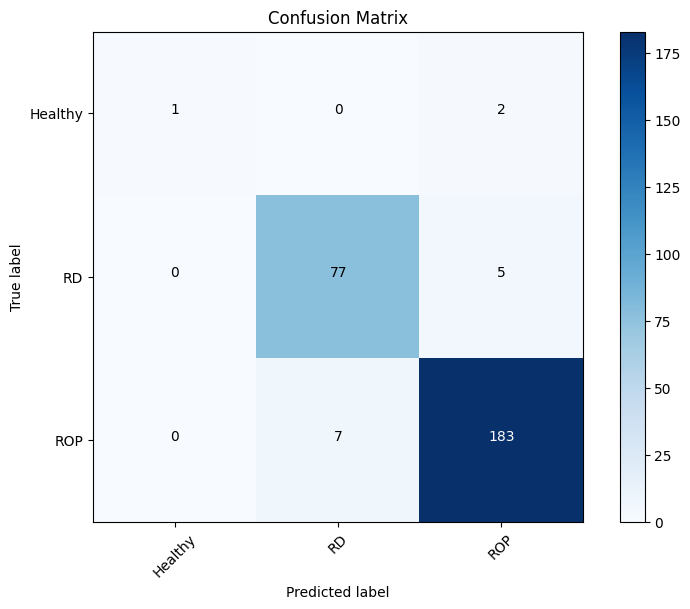

In [ ]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [ ]:
# Save the Model
SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'densenet_rop_model.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/My Drive/AIROP/robo_dataset/saved_models/densenet_rop_model.h5


# **EfficientNetB0**

## **Imports and Setup**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Dataset Paths and Parameters**

In [ ]:
# Path to dataset folders
BASE_DIR = '/content/drive/My Drive/AIROP/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

Preprocessing training images...


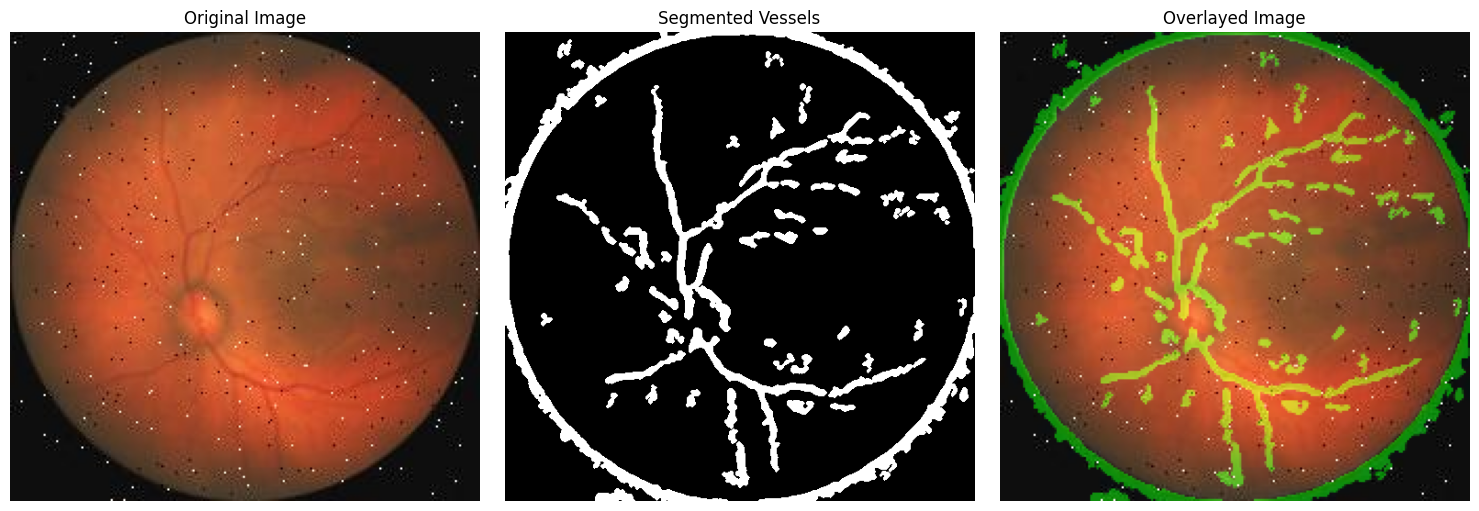

Preprocessing validation images...
Preprocessing test images...


In [ ]:
# Vessel Segmentation Functions
import cv2
from skimage import morphology, measure
def resize_image(image, size=(512, 512)):
    return cv2.resize(image, size)

def extract_green_channel(image):
    return image[:, :, 1]

def apply_clahe(image, clip_limit=1.5, tile_grid_size=(1, 1)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

def invert_image(image):
    return cv2.bitwise_not(image)

def apply_adaptive_threshold(image, block_size=25, C=6):
    thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    return invert_image(thresholded_image)

def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def morphology_opening(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphology_dilate(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(image, kernel)

def remove_small_objects(image, min_size=500):
    labels = measure.label(image)
    cleaned = morphology.remove_small_objects(labels, min_size=min_size)
    cleaned = (cleaned > 0).astype(np.uint8) * 255
    return cleaned

def vessel_segmentation(image):
    resized_image = resize_image(image)
    green_channel = extract_green_channel(resized_image)
    enhanced_image = apply_clahe(green_channel)
    adaptive_thresh_image = apply_adaptive_threshold(enhanced_image)
    median_filtered_image = apply_median_filter(adaptive_thresh_image)
    opened_image = morphology_opening(median_filtered_image, kernel_size=2)
    dilated_image = morphology_dilate(opened_image, kernel_size=3)
    final_image = remove_small_objects(dilated_image, min_size=100)
    return final_image

def overlay_segmentation(original_image, segmented_image):
    # Resize the segmented image to match the original image's dimensions
    segmented_image_resized = cv2.resize(segmented_image, (original_image.shape[1], original_image.shape[0]))

    # Convert the segmented image to a 3-channel mask
    mask = cv2.cvtColor(segmented_image_resized, cv2.COLOR_GRAY2BGR)

    # Apply a green overlay
    mask = cv2.bitwise_and(mask, np.array([0, 255, 0], dtype=np.uint8))  # Green overlay

    # Overlay the mask on the original image
    overlayed_image = cv2.addWeighted(original_image, 1, mask, 0.5, 0)
    return overlayed_image

# Function to preprocess images with vessel segmentation overlay
def preprocess_images(image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Traverse subdirectories (e.g., Healthy, ROP, RD)
    for class_name in os.listdir(image_dir):
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip if it's not a directory

        # Create corresponding output subdirectory
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        # Process each image in the subdirectory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Unable to read image {image_path}. Skipping.")
                continue  # Skip if the image is not valid

            # Apply vessel segmentation
            segmented_image = vessel_segmentation(original_image)

            # Overlay segmentation on the original image
            overlayed_image = overlay_segmentation(original_image, segmented_image)

            # Resize to the required input size for the model
            overlayed_image = cv2.resize(overlayed_image, (IMG_SIZE, IMG_SIZE))

            # Save the preprocessed image
            output_path = os.path.join(output_class_dir, image_name)
            cv2.imwrite(output_path, overlayed_image)

            # Plot the first image for visualization
            if not hasattr(preprocess_images, 'plot_done'):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(segmented_image, cmap='gray')
                plt.title("Segmented Vessels")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
                plt.title("Overlayed Image")
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                preprocess_images.plot_done = True  # Ensure plotting is done only once

# Preprocess training, validation, and test images
print("Preprocessing training images...")
preprocess_images(TRAIN_DIR, os.path.join(BASE_DIR, 'train_processed'))

print("Preprocessing validation images...")
preprocess_images(VALID_DIR, os.path.join(BASE_DIR, 'valid_processed'))

print("Preprocessing test images...")
preprocess_images(TEST_DIR, os.path.join(BASE_DIR, 'test_processed'))

# Update dataset paths to processed images
TRAIN_DIR_PROCESSED = os.path.join(BASE_DIR, 'train_processed')
VALID_DIR_PROCESSED = os.path.join(BASE_DIR, 'valid_processed')
TEST_DIR_PROCESSED = os.path.join(BASE_DIR, 'test_processed')

## **Data Augumentation and Preprocessing**

In [ ]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Model Building**

In [ ]:
# Build the Model
efficientnet_base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    efficientnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes as per your dataset (e.g., 3 for Healthy, ROP, RD)
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 4,011,391 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

## **Training**

In [ ]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_rop_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.6749 - auc: 0.8362 - loss: 0.7556 - precision: 0.7491 - recall: 0.5105
Epoch 1: val_loss improved from inf to 1.28197, saving model to best_rop_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 189s 963ms/step - accuracy: 0.6758 - auc: 0.8368 - loss: 0.7540 - precision: 0.7497 - recall: 0.5120 - val_accuracy: 0.0091 - val_auc: 0.1697 - val_loss: 1.2820 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.8918 - auc: 0.9734 - loss: 0.3075 - precision: 0.9000 - recall: 0.8810
Epoch 2: val_loss did not improve from 1.28197
122/122 ━━━━━━━━━━━━━━━━━━━━ 123s 591ms/step - accuracy: 0.8919 - auc: 0.9734 - loss: 0.3073 - precision: 0.9000 - recall: 0.8811 - val_accuracy: 0.0091 - val_auc: 0.1638 - val_loss: 1.4485 - val_precision: 0.0072 - val_recall: 0.0036
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.9217 - auc: 0.9857 - loss: 0.2193 - precisio

## **Plot Training History**

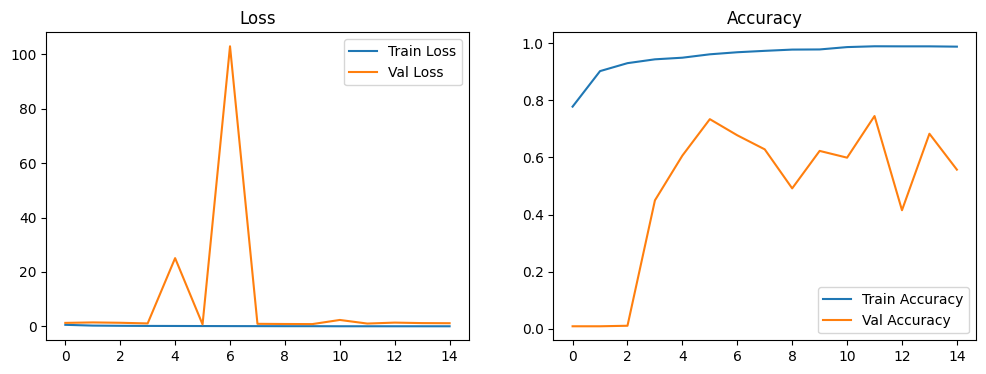

In [ ]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluation on Test Data**

In [ ]:
# Evaluate on Test Data
model.load_weights('best_rop_model.keras')
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 631ms/step - accuracy: 0.5677 - auc: 0.6949 - loss: 1.1217 - precision: 0.5681 - recall: 0.5180
Test Loss: 0.7176
Test Accuracy: 0.7455
Test Precision: 0.7649
Test Recall: 0.6982
Test AUC: 0.8602


## **Classification Report and Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 976ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.40      0.67      0.50         3
          RD       0.77      0.28      0.41        82
         ROP       0.75      0.95      0.84       190

    accuracy                           0.75       275
   macro avg       0.64      0.63      0.58       275
weighted avg       0.75      0.75      0.71       275


Confusion Matrix:
[[  2   0   1]
 [  0  23  59]
 [  3   7 180]]


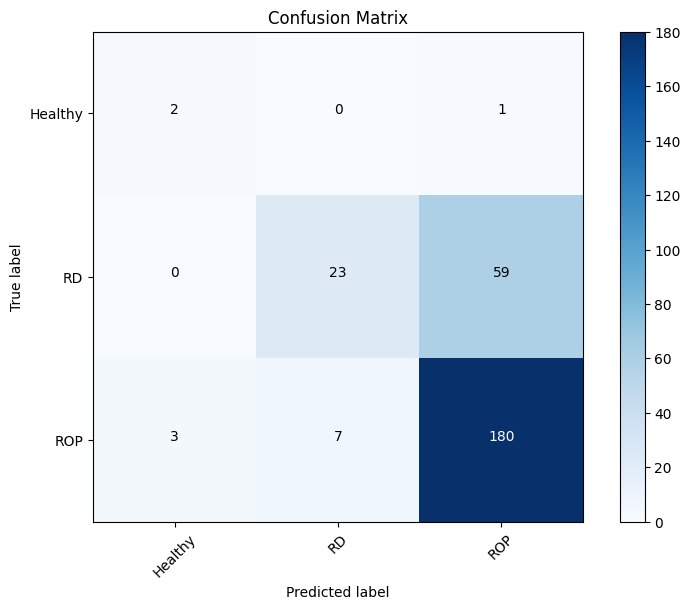

In [ ]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [ ]:
# Save the Model
SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'efficientnet_rop_model.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/My Drive/AIROP/robo_dataset/saved_models/efficientnet_rop_model.h5


# **Xception**

## **Import Libraries and Set Up Parameters**


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/content/drive/My Drive/AIROP/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

Preprocessing training images...


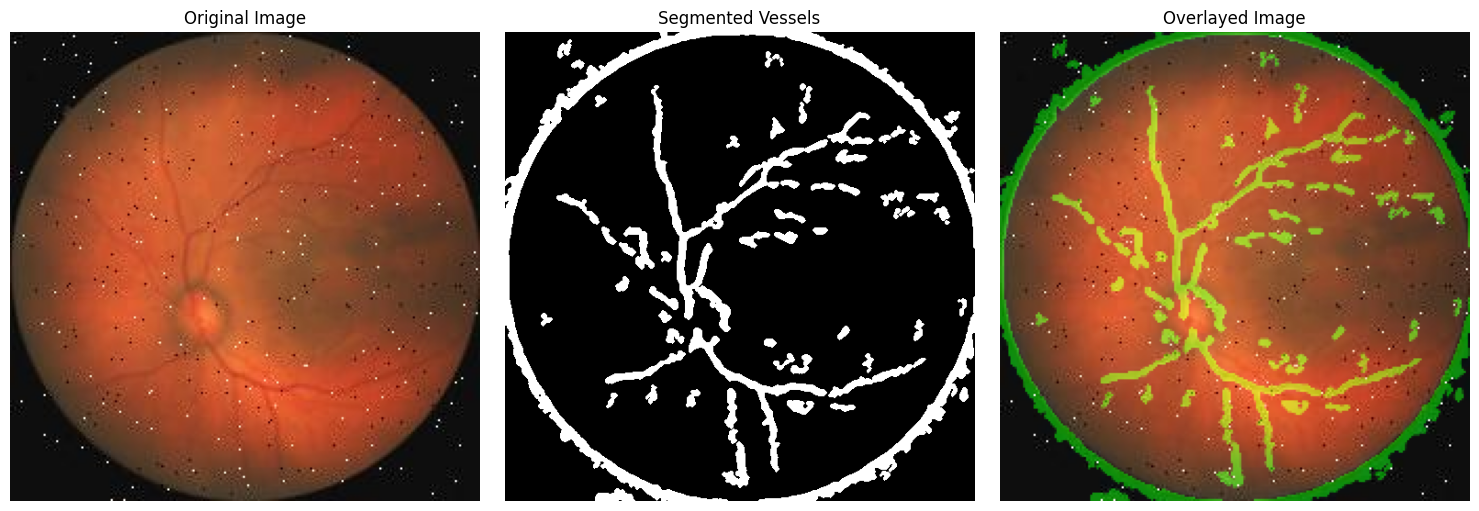

Preprocessing validation images...
Preprocessing test images...


In [ ]:
# Vessel Segmentation Functions
def resize_image(image, size=(512, 512)):
    return cv2.resize(image, size)

def extract_green_channel(image):
    return image[:, :, 1]

def apply_clahe(image, clip_limit=1.5, tile_grid_size=(1, 1)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

def invert_image(image):
    return cv2.bitwise_not(image)

def apply_adaptive_threshold(image, block_size=25, C=6):
    thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    return invert_image(thresholded_image)

def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def morphology_opening(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphology_dilate(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(image, kernel)

def remove_small_objects(image, min_size=500):
    labels = measure.label(image)
    cleaned = morphology.remove_small_objects(labels, min_size=min_size)
    cleaned = (cleaned > 0).astype(np.uint8) * 255
    return cleaned

def vessel_segmentation(image):
    resized_image = resize_image(image)
    green_channel = extract_green_channel(resized_image)
    enhanced_image = apply_clahe(green_channel)
    adaptive_thresh_image = apply_adaptive_threshold(enhanced_image)
    median_filtered_image = apply_median_filter(adaptive_thresh_image)
    opened_image = morphology_opening(median_filtered_image, kernel_size=2)
    dilated_image = morphology_dilate(opened_image, kernel_size=3)
    final_image = remove_small_objects(dilated_image, min_size=100)
    return final_image

def overlay_segmentation(original_image, segmented_image):
    # Resize the segmented image to match the original image's dimensions
    segmented_image_resized = cv2.resize(segmented_image, (original_image.shape[1], original_image.shape[0]))

    # Convert the segmented image to a 3-channel mask
    mask = cv2.cvtColor(segmented_image_resized, cv2.COLOR_GRAY2BGR)

    # Apply a green overlay
    mask = cv2.bitwise_and(mask, np.array([0, 255, 0], dtype=np.uint8))  # Green overlay

    # Overlay the mask on the original image
    overlayed_image = cv2.addWeighted(original_image, 1, mask, 0.5, 0)
    return overlayed_image

# Function to preprocess images with vessel segmentation overlay
def preprocess_images(image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Traverse subdirectories (e.g., Healthy, ROP, RD)
    for class_name in os.listdir(image_dir):
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip if it's not a directory

        # Create corresponding output subdirectory
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        # Process each image in the subdirectory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Unable to read image {image_path}. Skipping.")
                continue  # Skip if the image is not valid

            # Apply vessel segmentation
            segmented_image = vessel_segmentation(original_image)

            # Overlay segmentation on the original image
            overlayed_image = overlay_segmentation(original_image, segmented_image)

            # Resize to the required input size for the model
            overlayed_image = cv2.resize(overlayed_image, (IMG_SIZE, IMG_SIZE))

            # Save the preprocessed image
            output_path = os.path.join(output_class_dir, image_name)
            cv2.imwrite(output_path, overlayed_image)

            # Plot the first image for visualization
            if not hasattr(preprocess_images, 'plot_done'):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(segmented_image, cmap='gray')
                plt.title("Segmented Vessels")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
                plt.title("Overlayed Image")
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                preprocess_images.plot_done = True  # Ensure plotting is done only once

# Preprocess training, validation, and test images
print("Preprocessing training images...")
preprocess_images(TRAIN_DIR, os.path.join(BASE_DIR, 'train_processed'))

print("Preprocessing validation images...")
preprocess_images(VALID_DIR, os.path.join(BASE_DIR, 'valid_processed'))

print("Preprocessing test images...")
preprocess_images(TEST_DIR, os.path.join(BASE_DIR, 'test_processed'))

# Update dataset paths to processed images
TRAIN_DIR_PROCESSED = os.path.join(BASE_DIR, 'train_processed')
VALID_DIR_PROCESSED = os.path.join(BASE_DIR, 'valid_processed')
TEST_DIR_PROCESSED = os.path.join(BASE_DIR, 'test_processed')

## **Data Augmentation and Preprocessing**

In [ ]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Build the Model**

In [ ]:
# Build the Model
xception_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    xception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust for your number of classes
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 20,813,099 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

## **Train the Model**

In [ ]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_xception_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.7437 - auc: 0.8808 - loss: 0.6399 - precision: 0.8496 - recall: 0.5601
Epoch 1: val_loss improved from inf to 0.26731, saving model to best_xception_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 177s 989ms/step - accuracy: 0.7445 - auc: 0.8815 - loss: 0.6381 - precision: 0.8500 - recall: 0.5618 - val_accuracy: 0.8944 - val_auc: 0.9836 - val_loss: 0.2673 - val_precision: 0.8954 - val_recall: 0.8889
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.9404 - auc: 0.9915 - loss: 0.1677 - precision: 0.9454 - recall: 0.9354
Epoch 2: val_loss improved from 0.26731 to 0.06539, saving model to best_xception_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 94s 770ms/step - accuracy: 0.9404 - auc: 0.9915 - loss: 0.1677 - precision: 0.9454 - recall: 0.9354 - val_accuracy: 0.9800 - val_auc: 0.9973 - val_loss: 0.0654 - val_precision: 0.9835 - val_recall: 0.9800
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9

## **Plot Training History**

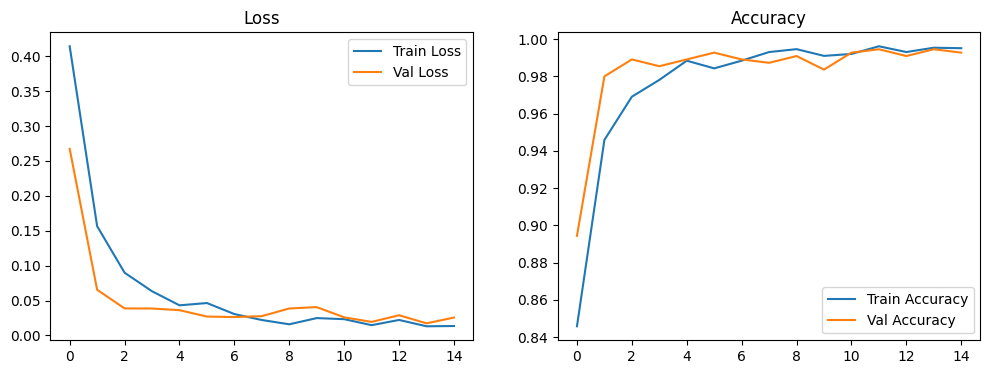

In [ ]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate the Model**

In [ ]:
# Evaluate the Model
model.load_weights('best_xception_model.keras')

test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 774ms/step - accuracy: 0.9816 - auc: 0.9996 - loss: 0.0477 - precision: 0.9816 - recall: 0.9816
Test Loss: 0.0236
Test Accuracy: 0.9927
Test Precision: 0.9927
Test Recall: 0.9927
Test AUC: 0.9999


## **Classification Report and Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 448ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00         3
          RD       1.00      0.98      0.99        82
         ROP       0.99      1.00      0.99       190

    accuracy                           0.99       275
   macro avg       1.00      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275


Confusion Matrix:
[[  3   0   0]
 [  0  80   2]
 [  0   0 190]]


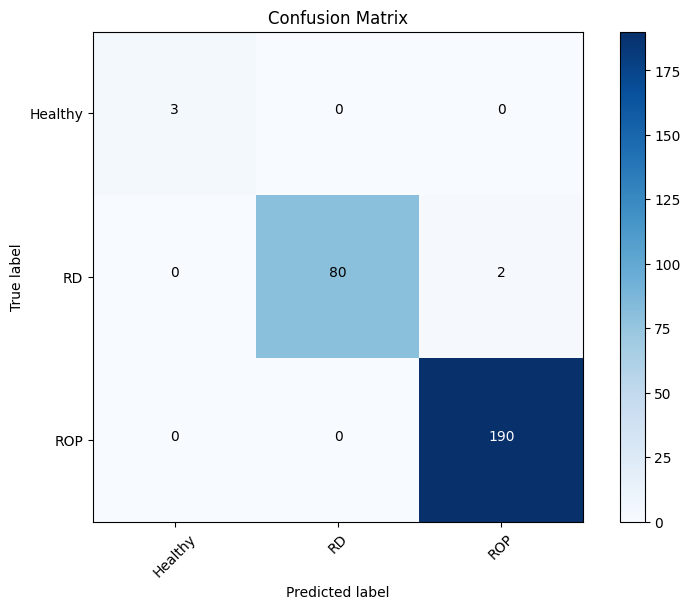

In [ ]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [ ]:
# Save the Model
SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'xception_rop_model.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/My Drive/AIROP/robo_dataset/saved_models/xception_rop_model.h5


# **InceptionV3**

## **Import Libraries and Set Up Parameters**


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/content/drive/My Drive/AIROP/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

Preprocessing training images...


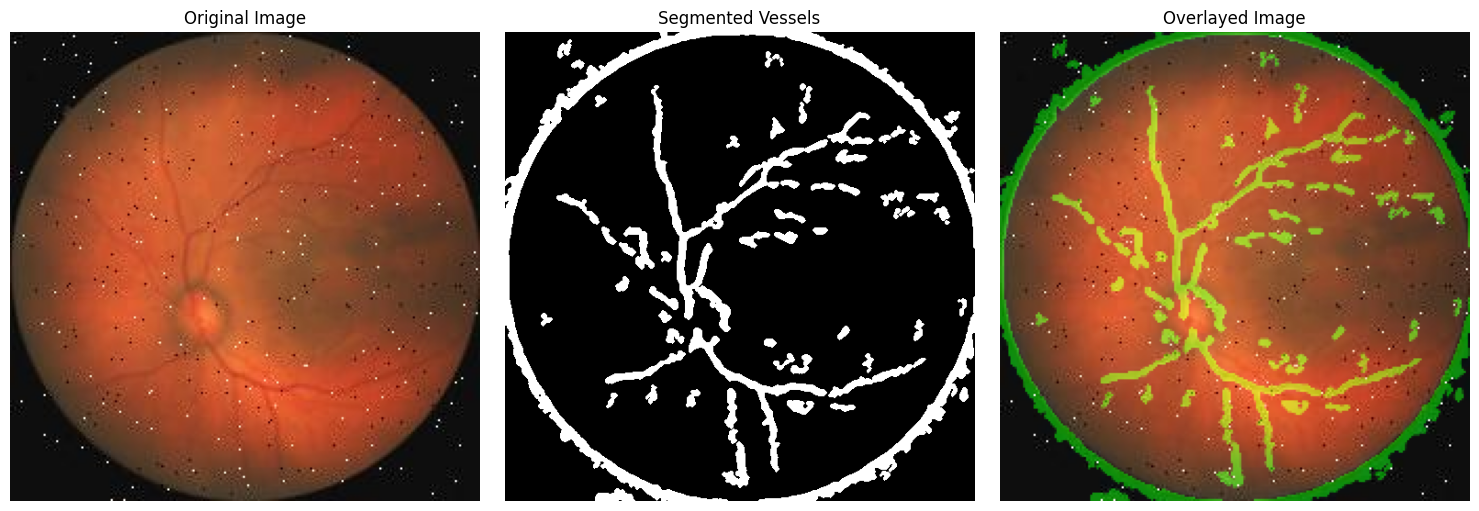

Preprocessing validation images...
Preprocessing test images...


In [ ]:
# Vessel Segmentation Functions
import cv2
from skimage import morphology, measure

def resize_image(image, size=(512, 512)):
    return cv2.resize(image, size)

def extract_green_channel(image):
    return image[:, :, 1]

def apply_clahe(image, clip_limit=1.5, tile_grid_size=(1, 1)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

def invert_image(image):
    return cv2.bitwise_not(image)

def apply_adaptive_threshold(image, block_size=25, C=6):
    thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    return invert_image(thresholded_image)

def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def morphology_opening(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphology_dilate(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(image, kernel)

def remove_small_objects(image, min_size=500):
    labels = measure.label(image)
    cleaned = morphology.remove_small_objects(labels, min_size=min_size)
    cleaned = (cleaned > 0).astype(np.uint8) * 255
    return cleaned

def vessel_segmentation(image):
    resized_image = resize_image(image)
    green_channel = extract_green_channel(resized_image)
    enhanced_image = apply_clahe(green_channel)
    adaptive_thresh_image = apply_adaptive_threshold(enhanced_image)
    median_filtered_image = apply_median_filter(adaptive_thresh_image)
    opened_image = morphology_opening(median_filtered_image, kernel_size=2)
    dilated_image = morphology_dilate(opened_image, kernel_size=3)
    final_image = remove_small_objects(dilated_image, min_size=100)
    return final_image

def overlay_segmentation(original_image, segmented_image):
    # Resize the segmented image to match the original image's dimensions
    segmented_image_resized = cv2.resize(segmented_image, (original_image.shape[1], original_image.shape[0]))

    # Convert the segmented image to a 3-channel mask
    mask = cv2.cvtColor(segmented_image_resized, cv2.COLOR_GRAY2BGR)

    # Apply a green overlay
    mask = cv2.bitwise_and(mask, np.array([0, 255, 0], dtype=np.uint8))  # Green overlay

    # Overlay the mask on the original image
    overlayed_image = cv2.addWeighted(original_image, 1, mask, 0.5, 0)
    return overlayed_image

# Function to preprocess images with vessel segmentation overlay
def preprocess_images(image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Traverse subdirectories (e.g., Healthy, ROP, RD)
    for class_name in os.listdir(image_dir):
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip if it's not a directory

        # Create corresponding output subdirectory
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        # Process each image in the subdirectory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Unable to read image {image_path}. Skipping.")
                continue  # Skip if the image is not valid

            # Apply vessel segmentation
            segmented_image = vessel_segmentation(original_image)

            # Overlay segmentation on the original image
            overlayed_image = overlay_segmentation(original_image, segmented_image)

            # Resize to the required input size for the model
            overlayed_image = cv2.resize(overlayed_image, (IMG_SIZE, IMG_SIZE))

            # Save the preprocessed image
            output_path = os.path.join(output_class_dir, image_name)
            cv2.imwrite(output_path, overlayed_image)

            # Plot the first image for visualization
            if not hasattr(preprocess_images, 'plot_done'):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(segmented_image, cmap='gray')
                plt.title("Segmented Vessels")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
                plt.title("Overlayed Image")
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                preprocess_images.plot_done = True  # Ensure plotting is done only once

# Preprocess training, validation, and test images
print("Preprocessing training images...")
preprocess_images(TRAIN_DIR, os.path.join(BASE_DIR, 'train_processed'))

print("Preprocessing validation images...")
preprocess_images(VALID_DIR, os.path.join(BASE_DIR, 'valid_processed'))

print("Preprocessing test images...")
preprocess_images(TEST_DIR, os.path.join(BASE_DIR, 'test_processed'))

# Update dataset paths to processed images
TRAIN_DIR_PROCESSED = os.path.join(BASE_DIR, 'train_processed')
VALID_DIR_PROCESSED = os.path.join(BASE_DIR, 'valid_processed')
TEST_DIR_PROCESSED = os.path.join(BASE_DIR, 'test_processed')

## **Data Augmentation and Preprocessing**

In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Build Model**

In [ ]:
inception_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    inception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model with additional metrics
model.compile(
    optimizer="adam",  # or any optimizer of your choice
    loss="categorical_crossentropy",  # or any loss function suitable for your problem
    metrics=[
        "accuracy",  # default metric
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

# Display the model architecture
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 21,774,499 (83.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

## **Train Model**

In [ ]:
checkpoint = ModelCheckpoint(
    'best_inception_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - accuracy: 0.7998 - auc: 0.9171 - loss: 0.5616 - precision: 0.8107 - recall: 0.7853
Epoch 1: val_loss improved from inf to 0.88852, saving model to best_inception_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.8003 - auc: 0.9174 - loss: 0.5603 - precision: 0.8112 - recall: 0.7858 - val_accuracy: 0.8525 - val_auc: 0.9415 - val_loss: 0.8885 - val_precision: 0.8579 - val_recall: 0.8470
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.9175 - auc: 0.9805 - loss: 0.2491 - precision: 0.9207 - recall: 0.9159
Epoch 2: val_loss improved from 0.88852 to 0.66257, saving model to best_inception_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 109s 884ms/step - accuracy: 0.9175 - auc: 0.9805 - loss: 0.2491 - precision: 0.9207 - recall: 0.9159 - val_accuracy: 0.7705 - val_auc: 0.9043 - val_loss: 0.6626 - val_precision: 0.7780 - val_recall: 0.7213
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.9

## **Plotting Training History**

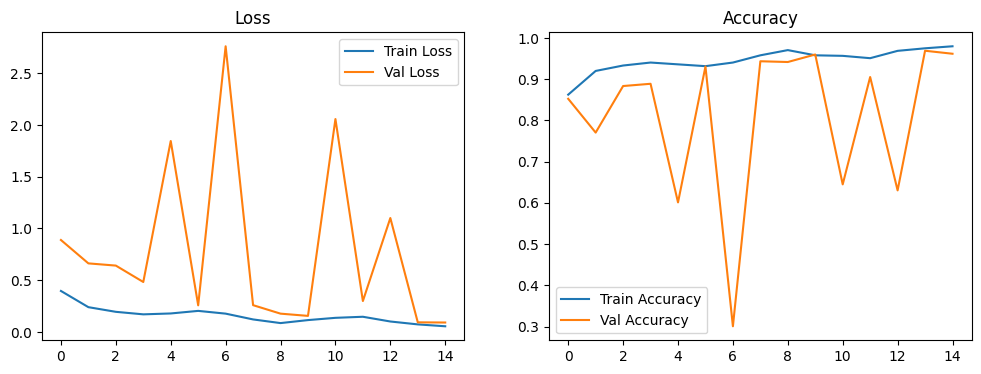

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate on Test data**

In [ ]:
model.load_weights('best_inception_model.keras')
# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
# model.load_weights('best_xception_model.keras')

test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 892ms/step - accuracy: 0.9429 - auc: 0.9822 - loss: 0.1902 - precision: 0.9429 - recall: 0.9429
Test Loss: 0.0902
Test Accuracy: 0.9709
Test Precision: 0.9709
Test Recall: 0.9709
Test AUC: 0.9943


## **Classification Report and Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 785ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.75      1.00      0.86         3
          RD       1.00      0.91      0.96        82
         ROP       0.96      0.99      0.98       190

    accuracy                           0.97       275
   macro avg       0.90      0.97      0.93       275
weighted avg       0.97      0.97      0.97       275


Confusion Matrix:
[[  3   0   0]
 [  0  75   7]
 [  1   0 189]]


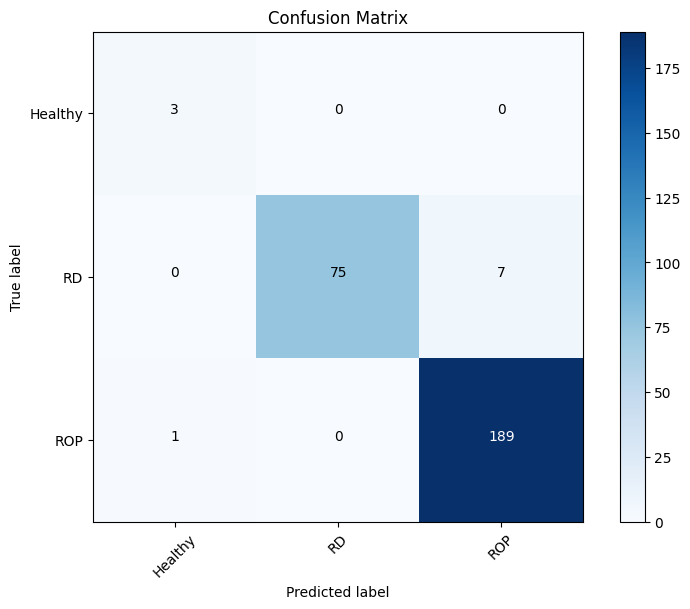

In [ ]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Saving Model

In [ ]:
# Save the Model
SAVE_DIR = os.path.join(BASE_DIR, 'saved_Overlay_models')
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'inceptionV3_rop_model.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

# **MobileNetV3**

## **Import Libraries and Set Up Parameters**



In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV3Large
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

In [ ]:
# Vessel Segmentation Functions
import cv2
from skimage import morphology, measure

def resize_image(image, size=(512, 512)):
    return cv2.resize(image, size)

def extract_green_channel(image):
    return image[:, :, 1]

def apply_clahe(image, clip_limit=1.5, tile_grid_size=(1, 1)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

def invert_image(image):
    return cv2.bitwise_not(image)

def apply_adaptive_threshold(image, block_size=25, C=6):
    thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    return invert_image(thresholded_image)

def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def morphology_opening(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphology_dilate(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(image, kernel)

def remove_small_objects(image, min_size=500):
    labels = measure.label(image)
    cleaned = morphology.remove_small_objects(labels, min_size=min_size)
    cleaned = (cleaned > 0).astype(np.uint8) * 255
    return cleaned

def vessel_segmentation(image):
    resized_image = resize_image(image)
    green_channel = extract_green_channel(resized_image)
    enhanced_image = apply_clahe(green_channel)
    adaptive_thresh_image = apply_adaptive_threshold(enhanced_image)
    median_filtered_image = apply_median_filter(adaptive_thresh_image)
    opened_image = morphology_opening(median_filtered_image, kernel_size=2)
    dilated_image = morphology_dilate(opened_image, kernel_size=3)
    final_image = remove_small_objects(dilated_image, min_size=100)
    return final_image

def overlay_segmentation(original_image, segmented_image):
    # Resize the segmented image to match the original image's dimensions
    segmented_image_resized = cv2.resize(segmented_image, (original_image.shape[1], original_image.shape[0]))

    # Convert the segmented image to a 3-channel mask
    mask = cv2.cvtColor(segmented_image_resized, cv2.COLOR_GRAY2BGR)

    # Apply a green overlay
    mask = cv2.bitwise_and(mask, np.array([0, 255, 0], dtype=np.uint8))  # Green overlay

    # Overlay the mask on the original image
    overlayed_image = cv2.addWeighted(original_image, 1, mask, 0.5, 0)
    return overlayed_image

# Function to preprocess images with vessel segmentation overlay
def preprocess_images(image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Traverse subdirectories (e.g., Healthy, ROP, RD)
    for class_name in os.listdir(image_dir):
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip if it's not a directory

        # Create corresponding output subdirectory
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        # Process each image in the subdirectory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Unable to read image {image_path}. Skipping.")
                continue  # Skip if the image is not valid

            # Apply vessel segmentation
            segmented_image = vessel_segmentation(original_image)

            # Overlay segmentation on the original image
            overlayed_image = overlay_segmentation(original_image, segmented_image)

            # Resize to the required input size for the model
            overlayed_image = cv2.resize(overlayed_image, (IMG_SIZE, IMG_SIZE))

            # Save the preprocessed image
            output_path = os.path.join(output_class_dir, image_name)
            cv2.imwrite(output_path, overlayed_image)

            # Plot the first image for visualization
            if not hasattr(preprocess_images, 'plot_done'):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(segmented_image, cmap='gray')
                plt.title("Segmented Vessels")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
                plt.title("Overlayed Image")
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                preprocess_images.plot_done = True  # Ensure plotting is done only once

# Preprocess training, validation, and test images
print("Preprocessing training images...")
preprocess_images(TRAIN_DIR, os.path.join(BASE_DIR, 'train_processed'))

print("Preprocessing validation images...")
preprocess_images(VALID_DIR, os.path.join(BASE_DIR, 'valid_processed'))

print("Preprocessing test images...")
preprocess_images(TEST_DIR, os.path.join(BASE_DIR, 'test_processed'))

# Update dataset paths to processed images
TRAIN_DIR_PROCESSED = os.path.join(BASE_DIR, 'train_processed')
VALID_DIR_PROCESSED = os.path.join(BASE_DIR, 'valid_processed')
TEST_DIR_PROCESSED = os.path.join(BASE_DIR, 'test_processed')

## **Data Augmentation and Preprocessing**

In [2]:
# Update dataset paths to processed images
TRAIN_DIR_PROCESSED = os.path.join(BASE_DIR, 'train_processed')
VALID_DIR_PROCESSED = os.path.join(BASE_DIR, 'valid_processed')
TEST_DIR_PROCESSED = os.path.join(BASE_DIR, 'test_processed')

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Build Model**

In [10]:
mobilenetv3_base = MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    mobilenetv3_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           2,883 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,999,235 (11.44 MB)

 Trainable params: 2,974,835 (11.35 MB)

 Non-trainable params: 24,400 (95.31 KB)

## **Train the Model**

In [11]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_mobilenetv3_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.6907 - auc: 0.8496 - loss: 0.7122 - precision: 0.7136 - recall: 0.6485
Epoch 1: val_loss improved from inf to 1.31594, saving model to best_mobilenetv3_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 149s 783ms/step - accuracy: 0.6916 - auc: 0.8503 - loss: 0.7105 - precision: 0.7145 - recall: 0.6496 - val_accuracy: 0.2914 - val_auc: 0.6586 - val_loss: 1.3159 - val_precision: 0.2914 - val_recall: 0.2914
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9142 - auc: 0.9829 - loss: 0.2413 - precision: 0.9157 - recall: 0.9099
Epoch 2: val_loss did not improve from 1.31594
122/122 ━━━━━━━━━━━━━━━━━━━━ 49s 381ms/step - accuracy: 0.9143 - auc: 0.9830 - loss: 0.2413 - precision: 0.9158 - recall: 0.9099 - val_accuracy: 0.2914 - val_auc: 0.6560 - val_loss: 1.3400 - val_precision: 0.2914 - val_recall: 0.2914
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9328 - auc: 0.9893 - loss: 0.1883 - precision: 0.9373 - 

## **Plotting Training History**

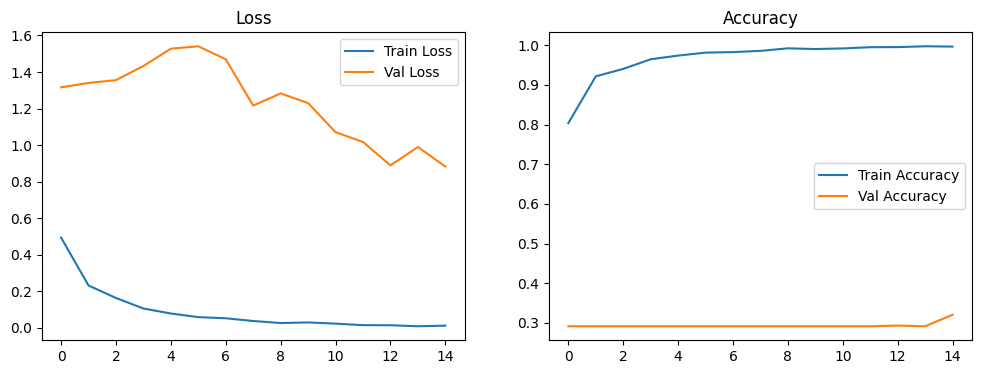

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate on Test Data**

In [13]:
model.load_weights('best_mobilenetv3_model.keras')
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Calculate and print mean training accuracy
mean_train_accuracy = np.mean(history.history['accuracy'])
print(f"Mean Training Accuracy: {mean_train_accuracy:.4f}")

# Calculate and print mean validation accuracy
mean_val_accuracy = np.mean(history.history['val_accuracy'])
print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 755ms/step - accuracy: 0.5694 - auc: 0.7862 - loss: 0.7895 - precision: 0.5667 - recall: 0.5368
Test Loss: 0.8955
Test Accuracy: 0.3164
Test Precision: 0.3062
Test Recall: 0.2873
Test AUC: 0.6587
Mean Training Accuracy: 0.9676
Mean Validation Accuracy: 0.2935


## **Classification Report and Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 486ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.30      1.00      0.47        82
         ROP       1.00      0.03      0.05       190

    accuracy                           0.32       275
   macro avg       0.43      0.34      0.17       275
weighted avg       0.78      0.32      0.17       275


Confusion Matrix:
[[  0   3   0]
 [  0  82   0]
 [  0 185   5]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


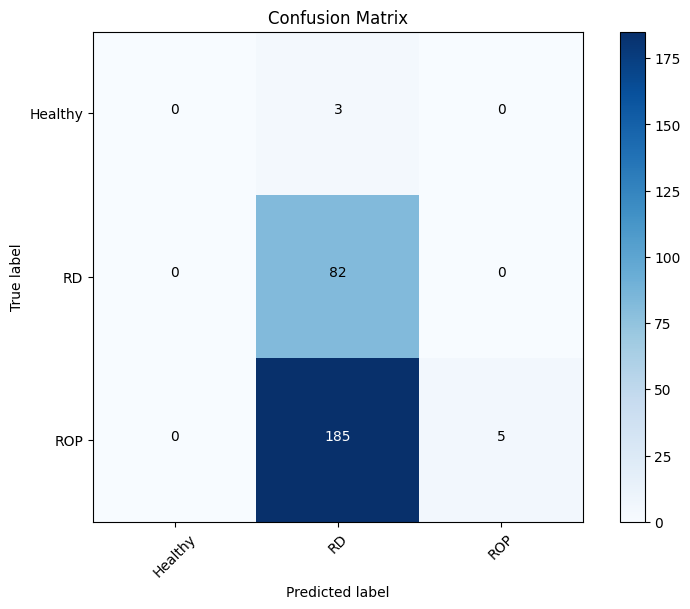

In [14]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

save Model

In [15]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'mobilenetv3_rop_model_o.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/mobilenetv3_rop_model_o.h5


# **VGG16**


## **Import Libraries and Set Up parameters**

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

In [ ]:
# Vessel Segmentation Functions
import cv2
from skimage import morphology, measure

def resize_image(image, size=(512, 512)):
    return cv2.resize(image, size)

def extract_green_channel(image):
    return image[:, :, 1]

def apply_clahe(image, clip_limit=1.5, tile_grid_size=(1, 1)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

def invert_image(image):
    return cv2.bitwise_not(image)

def apply_adaptive_threshold(image, block_size=25, C=6):
    thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    return invert_image(thresholded_image)

def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def morphology_opening(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphology_dilate(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(image, kernel)

def remove_small_objects(image, min_size=500):
    labels = measure.label(image)
    cleaned = morphology.remove_small_objects(labels, min_size=min_size)
    cleaned = (cleaned > 0).astype(np.uint8) * 255
    return cleaned

def vessel_segmentation(image):
    resized_image = resize_image(image)
    green_channel = extract_green_channel(resized_image)
    enhanced_image = apply_clahe(green_channel)
    adaptive_thresh_image = apply_adaptive_threshold(enhanced_image)
    median_filtered_image = apply_median_filter(adaptive_thresh_image)
    opened_image = morphology_opening(median_filtered_image, kernel_size=2)
    dilated_image = morphology_dilate(opened_image, kernel_size=3)
    final_image = remove_small_objects(dilated_image, min_size=100)
    return final_image

def overlay_segmentation(original_image, segmented_image):
    # Resize the segmented image to match the original image's dimensions
    segmented_image_resized = cv2.resize(segmented_image, (original_image.shape[1], original_image.shape[0]))

    # Convert the segmented image to a 3-channel mask
    mask = cv2.cvtColor(segmented_image_resized, cv2.COLOR_GRAY2BGR)

    # Apply a green overlay
    mask = cv2.bitwise_and(mask, np.array([0, 255, 0], dtype=np.uint8))  # Green overlay

    # Overlay the mask on the original image
    overlayed_image = cv2.addWeighted(original_image, 1, mask, 0.5, 0)
    return overlayed_image

# Function to preprocess images with vessel segmentation overlay
def preprocess_images(image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Traverse subdirectories (e.g., Healthy, ROP, RD)
    for class_name in os.listdir(image_dir):
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip if it's not a directory

        # Create corresponding output subdirectory
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        # Process each image in the subdirectory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Unable to read image {image_path}. Skipping.")
                continue  # Skip if the image is not valid

            # Apply vessel segmentation
            segmented_image = vessel_segmentation(original_image)

            # Overlay segmentation on the original image
            overlayed_image = overlay_segmentation(original_image, segmented_image)

            # Resize to the required input size for the model
            overlayed_image = cv2.resize(overlayed_image, (IMG_SIZE, IMG_SIZE))

            # Save the preprocessed image
            output_path = os.path.join(output_class_dir, image_name)
            cv2.imwrite(output_path, overlayed_image)

            # Plot the first image for visualization
            if not hasattr(preprocess_images, 'plot_done'):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(segmented_image, cmap='gray')
                plt.title("Segmented Vessels")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
                plt.title("Overlayed Image")
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                preprocess_images.plot_done = True  # Ensure plotting is done only once

# Preprocess training, validation, and test images
print("Preprocessing training images...")
preprocess_images(TRAIN_DIR, os.path.join(BASE_DIR, 'train_processed'))

print("Preprocessing validation images...")
preprocess_images(VALID_DIR, os.path.join(BASE_DIR, 'valid_processed'))

print("Preprocessing test images...")
preprocess_images(TEST_DIR, os.path.join(BASE_DIR, 'test_processed'))

In [6]:
# Update dataset paths to processed images
TRAIN_DIR_PROCESSED = os.path.join(BASE_DIR, 'train_processed')
VALID_DIR_PROCESSED = os.path.join(BASE_DIR, 'valid_processed')
TEST_DIR_PROCESSED = os.path.join(BASE_DIR, 'test_processed')

## **Data Augmentation and Preprocessing**

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Build the Model**

In [8]:
vgg_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Add custom layers on top
model = Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model
model.compile(
    optimizer="adam",  # Can experiment with other optimizers like SGD
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,716,227 (56.14 MB)

 Trainable params: 14,716,227 (56.14 MB)

 Non-trainable params: 0 (0.00 B)

## **Train the Model**

In [9]:
checkpoint = ModelCheckpoint(
    'best_vgg_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.6306 - auc: 0.8245 - loss: 1.5199 - precision: 0.6439 - recall: 0.5969
Epoch 1: val_loss improved from inf to 0.66263, saving model to best_vgg_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 119s 755ms/step - accuracy: 0.6310 - auc: 0.8247 - loss: 1.5148 - precision: 0.6443 - recall: 0.5975 - val_accuracy: 0.6995 - val_auc: 0.8614 - val_loss: 0.6626 - val_precision: 0.6995 - val_recall: 0.6995
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.7112 - auc: 0.8478 - loss: 0.6909 - precision: 0.7126 - recall: 0.7108
Epoch 2: val_loss improved from 0.66263 to 0.63708, saving model to best_vgg_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 52s 402ms/step - accuracy: 0.7112 - auc: 0.8479 - loss: 0.6907 - precision: 0.7126 - recall: 0.7109 - val_accuracy: 0.6995 - val_auc: 0.8828 - val_loss: 0.6371 - val_precision: 0.6995 - val_recall: 0.6995
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7132 - auc: 0.8652 - l

## **Plotting training History**

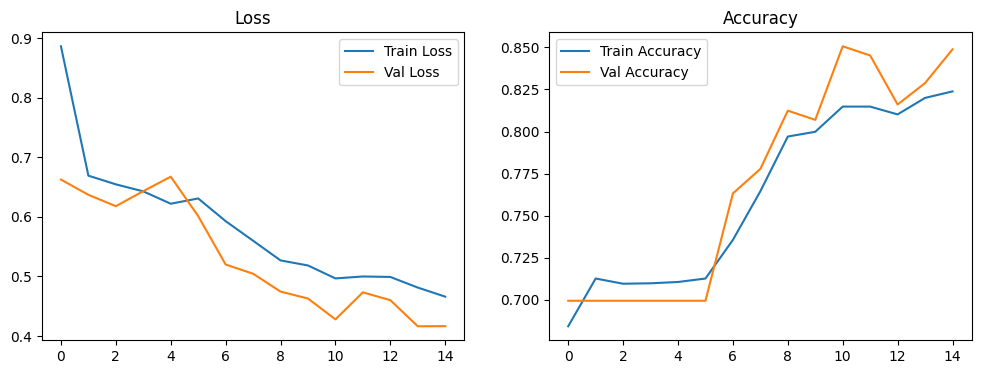

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


## **Evaluate on Test Data**

In [11]:
model.load_weights('best_vgg_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Calculate and print mean training accuracy
mean_train_accuracy = np.mean(history.history['accuracy'])
print(f"Mean Training Accuracy: {mean_train_accuracy:.4f}")

# Calculate and print mean validation accuracy
mean_val_accuracy = np.mean(history.history['val_accuracy'])
print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 848ms/step - accuracy: 0.7261 - auc: 0.8760 - loss: 0.6440 - precision: 0.7243 - recall: 0.7200
Test Loss: 0.4536
Test Accuracy: 0.8109
Test Precision: 0.8102
Test Recall: 0.8073
Test AUC: 0.9403
Mean Training Accuracy: 0.7613
Mean Validation Accuracy: 0.7698


## **Classification Report and Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.73      0.63      0.68        82
         ROP       0.84      0.90      0.87       190

    accuracy                           0.81       275
   macro avg       0.52      0.51      0.52       275
weighted avg       0.80      0.81      0.80       275


Confusion Matrix:
[[  0   0   3]
 [  0  52  30]
 [  0  19 171]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


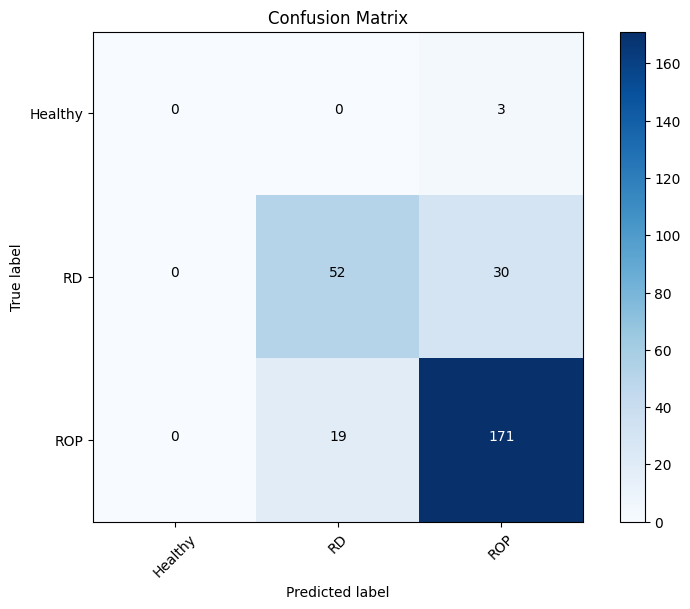

In [12]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save Model**

In [13]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'vgg16_rop_model_o.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/vgg16_rop_model_o.h5


# **setting up dataset (not needed)**

In [ ]:
# Install and download dataset
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CdeZJVrKXJQvsNCBSvks")
project = rf.workspace("airop").project("rop-vj9t0")
version = project.version(3)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ROP-3 in folder:: 100%|██████████| 4704/4704 [00:00<00:00, 8179.74it/s]


# **EfficientNetV2-L**

## **Import Libraries**

In [28]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetV2L
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Set Up Parameters**

In [ ]:
# Dataset paths
BASE_DIR = '/content/drive/My Drive/AIROP/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15


In [ ]:
# Vessel Segmentation Functions
import cv2
from skimage import morphology, measure

def resize_image(image, size=(512, 512)):
    return cv2.resize(image, size)

def extract_green_channel(image):
    return image[:, :, 1]

def apply_clahe(image, clip_limit=1.5, tile_grid_size=(1, 1)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

def invert_image(image):
    return cv2.bitwise_not(image)

def apply_adaptive_threshold(image, block_size=25, C=6):
    thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    return invert_image(thresholded_image)

def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def morphology_opening(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphology_dilate(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(image, kernel)

def remove_small_objects(image, min_size=500):
    labels = measure.label(image)
    cleaned = morphology.remove_small_objects(labels, min_size=min_size)
    cleaned = (cleaned > 0).astype(np.uint8) * 255
    return cleaned

def vessel_segmentation(image):
    resized_image = resize_image(image)
    green_channel = extract_green_channel(resized_image)
    enhanced_image = apply_clahe(green_channel)
    adaptive_thresh_image = apply_adaptive_threshold(enhanced_image)
    median_filtered_image = apply_median_filter(adaptive_thresh_image)
    opened_image = morphology_opening(median_filtered_image, kernel_size=2)
    dilated_image = morphology_dilate(opened_image, kernel_size=3)
    final_image = remove_small_objects(dilated_image, min_size=100)
    return final_image

def overlay_segmentation(original_image, segmented_image):
    # Resize the segmented image to match the original image's dimensions
    segmented_image_resized = cv2.resize(segmented_image, (original_image.shape[1], original_image.shape[0]))

    # Convert the segmented image to a 3-channel mask
    mask = cv2.cvtColor(segmented_image_resized, cv2.COLOR_GRAY2BGR)

    # Apply a green overlay
    mask = cv2.bitwise_and(mask, np.array([0, 255, 0], dtype=np.uint8))  # Green overlay

    # Overlay the mask on the original image
    overlayed_image = cv2.addWeighted(original_image, 1, mask, 0.5, 0)
    return overlayed_image

# Function to preprocess images with vessel segmentation overlay
def preprocess_images(image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Traverse subdirectories (e.g., Healthy, ROP, RD)
    for class_name in os.listdir(image_dir):
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip if it's not a directory

        # Create corresponding output subdirectory
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        # Process each image in the subdirectory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Unable to read image {image_path}. Skipping.")
                continue  # Skip if the image is not valid

            # Apply vessel segmentation
            segmented_image = vessel_segmentation(original_image)

            # Overlay segmentation on the original image
            overlayed_image = overlay_segmentation(original_image, segmented_image)

            # Resize to the required input size for the model
            overlayed_image = cv2.resize(overlayed_image, (IMG_SIZE, IMG_SIZE))

            # Save the preprocessed image
            output_path = os.path.join(output_class_dir, image_name)
            cv2.imwrite(output_path, overlayed_image)

            # Plot the first image for visualization
            if not hasattr(preprocess_images, 'plot_done'):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(segmented_image, cmap='gray')
                plt.title("Segmented Vessels")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
                plt.title("Overlayed Image")
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                preprocess_images.plot_done = True  # Ensure plotting is done only once

# Preprocess training, validation, and test images
print("Preprocessing training images...")
preprocess_images(TRAIN_DIR, os.path.join(BASE_DIR, 'train_processed'))

print("Preprocessing validation images...")
preprocess_images(VALID_DIR, os.path.join(BASE_DIR, 'valid_processed'))

print("Preprocessing test images...")
preprocess_images(TEST_DIR, os.path.join(BASE_DIR, 'test_processed'))

# Update dataset paths to processed images
TRAIN_DIR_PROCESSED = os.path.join(BASE_DIR, 'train_processed')
VALID_DIR_PROCESSED = os.path.join(BASE_DIR, 'valid_processed')
TEST_DIR_PROCESSED = os.path.join(BASE_DIR, 'test_processed')

## **Data Preprocessing and Augmentation**

In [29]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Build Function**

In [30]:
# Build and Compile the Model
# Load EfficientNetV2L
regnet_base = EfficientNetV2L(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    regnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)        │ (None, 7, 7, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,750,691 (449.18 MB)

 Trainable params: 117,238,115 (447.23 MB)

 Non-trainable params: 512,576 (1.96 MB)

## **Train Model**

In [31]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_efficientnetv2_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7984 - auc: 0.9199 - loss: 0.5212 - precision: 0.8245 - recall: 0.7558
Epoch 1: val_loss improved from inf to 0.67583, saving model to best_efficientnetv2_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step - accuracy: 0.7988 - auc: 0.9202 - loss: 0.5203 - precision: 0.8248 - recall: 0.7564 - val_accuracy: 0.6995 - val_auc: 0.8755 - val_loss: 0.6758 - val_precision: 0.7111 - val_recall: 0.6995
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.8999 - auc: 0.9755 - loss: 0.2844 - precision: 0.9025 - recall: 0.8960
Epoch 2: val_loss did not improve from 0.67583
122/122 ━━━━━━━━━━━━━━━━━━━━ 89s 702ms/step - accuracy: 0.9000 - auc: 0.9755 - loss: 0.2843 - precision: 0.9025 - recall: 0.8961 - val_accuracy: 0.6995 - val_auc: 0.8296 - val_loss: 0.7645 - val_precision: 0.6995 - val_recall: 0.6995
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.9215 - auc: 0.9837 - loss: 0.2286 - precision: 0.9238 - rec

## **Plot Training History**

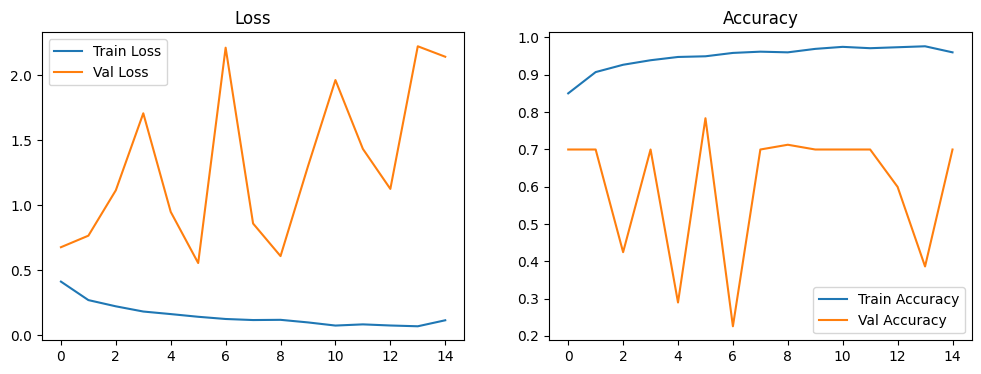

In [32]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


## **Evaluate the Model on Test Data**

In [33]:
# Evaluate the Model on Test Data
model.load_weights('best_efficientnetv2_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Generate Classification Report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5634 - auc: 0.8043 - loss: 0.7717 - precision: 0.5949 - recall: 0.5162
Test Loss: 0.5570
Test Accuracy: 0.7527
Test Precision: 0.7984
Test Recall: 0.7200
Test AUC: 0.9240
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step 

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.50      0.33      0.40         3
          RD       0.74      0.30      0.43        82
         ROP       0.76      0.95      0.84       190

    accuracy                           0.75       275
   macro avg       0.66      0.53      0.56       275
weighted avg       0.75      0.75      0.72       275



## **Confusion Matrix**


Confusion Matrix:
[[  1   0   2]
 [  1  25  56]
 [  0   9 181]]


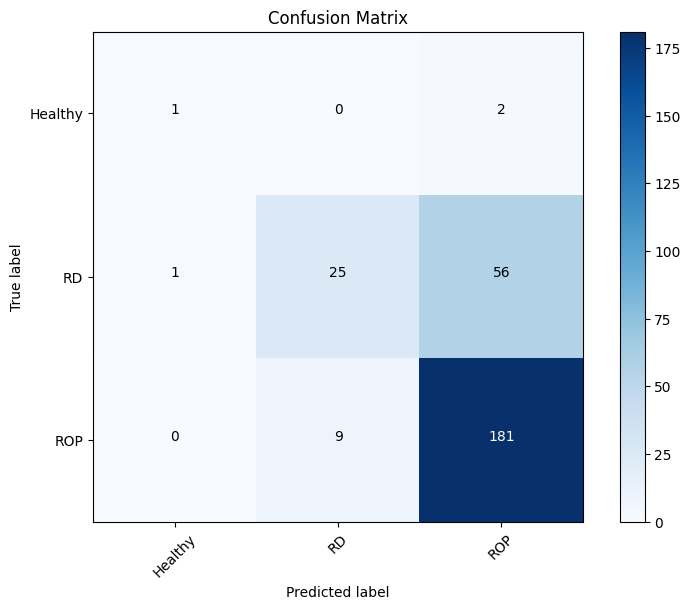

In [35]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [36]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'efficientnetv2_rop_model_o.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/efficientnetv2_rop_model_o.h5


# **ResNet50V2**

## **Import Libraries**

In [63]:
# Import Libraries and Set Random Seeds
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50V2
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## **Dataset Paths and Parameters**

In [ ]:
# Define dataset paths and parameters
BASE_DIR = '/content/drive/My Drive/AIROP/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

In [ ]:
# Vessel Segmentation Functions
import cv2
from skimage import morphology, measure

def resize_image(image, size=(512, 512)):
    return cv2.resize(image, size)

def extract_green_channel(image):
    return image[:, :, 1]

def apply_clahe(image, clip_limit=1.5, tile_grid_size=(1, 1)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

def invert_image(image):
    return cv2.bitwise_not(image)

def apply_adaptive_threshold(image, block_size=25, C=6):
    thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    return invert_image(thresholded_image)

def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def morphology_opening(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphology_dilate(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(image, kernel)

def remove_small_objects(image, min_size=500):
    labels = measure.label(image)
    cleaned = morphology.remove_small_objects(labels, min_size=min_size)
    cleaned = (cleaned > 0).astype(np.uint8) * 255
    return cleaned

def vessel_segmentation(image):
    resized_image = resize_image(image)
    green_channel = extract_green_channel(resized_image)
    enhanced_image = apply_clahe(green_channel)
    adaptive_thresh_image = apply_adaptive_threshold(enhanced_image)
    median_filtered_image = apply_median_filter(adaptive_thresh_image)
    opened_image = morphology_opening(median_filtered_image, kernel_size=2)
    dilated_image = morphology_dilate(opened_image, kernel_size=3)
    final_image = remove_small_objects(dilated_image, min_size=100)
    return final_image

def overlay_segmentation(original_image, segmented_image):
    # Resize the segmented image to match the original image's dimensions
    segmented_image_resized = cv2.resize(segmented_image, (original_image.shape[1], original_image.shape[0]))

    # Convert the segmented image to a 3-channel mask
    mask = cv2.cvtColor(segmented_image_resized, cv2.COLOR_GRAY2BGR)

    # Apply a green overlay
    mask = cv2.bitwise_and(mask, np.array([0, 255, 0], dtype=np.uint8))  # Green overlay

    # Overlay the mask on the original image
    overlayed_image = cv2.addWeighted(original_image, 1, mask, 0.5, 0)
    return overlayed_image

# Function to preprocess images with vessel segmentation overlay
def preprocess_images(image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Traverse subdirectories (e.g., Healthy, ROP, RD)
    for class_name in os.listdir(image_dir):
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip if it's not a directory

        # Create corresponding output subdirectory
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        # Process each image in the subdirectory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Unable to read image {image_path}. Skipping.")
                continue  # Skip if the image is not valid

            # Apply vessel segmentation
            segmented_image = vessel_segmentation(original_image)

            # Overlay segmentation on the original image
            overlayed_image = overlay_segmentation(original_image, segmented_image)

            # Resize to the required input size for the model
            overlayed_image = cv2.resize(overlayed_image, (IMG_SIZE, IMG_SIZE))

            # Save the preprocessed image
            output_path = os.path.join(output_class_dir, image_name)
            cv2.imwrite(output_path, overlayed_image)

            # Plot the first image for visualization
            if not hasattr(preprocess_images, 'plot_done'):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(segmented_image, cmap='gray')
                plt.title("Segmented Vessels")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
                plt.title("Overlayed Image")
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                preprocess_images.plot_done = True  # Ensure plotting is done only once

# Preprocess training, validation, and test images
print("Preprocessing training images...")
preprocess_images(TRAIN_DIR, os.path.join(BASE_DIR, 'train_processed'))

print("Preprocessing validation images...")
preprocess_images(VALID_DIR, os.path.join(BASE_DIR, 'valid_processed'))

print("Preprocessing test images...")
preprocess_images(TEST_DIR, os.path.join(BASE_DIR, 'test_processed'))

# Update dataset paths to processed images
TRAIN_DIR_PROCESSED = os.path.join(BASE_DIR, 'train_processed')
VALID_DIR_PROCESSED = os.path.join(BASE_DIR, 'valid_processed')
TEST_DIR_PROCESSED = os.path.join(BASE_DIR, 'test_processed')

## **Data Preprocessing and Augmentation**

In [65]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Function for Building Model**

In [66]:
# Build and Compile the Model
# Load ResNet50V2
resnext_base = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    resnext_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes
])
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,570,947 (89.92 MB)

 Trainable params: 23,525,507 (89.74 MB)

 Non-trainable params: 45,440 (177.50 KB)

## **Train the Model**

In [67]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_resnet50v2_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.7447 - auc: 0.8928 - loss: 0.6303 - precision: 0.7577 - recall: 0.7107
Epoch 1: val_loss improved from inf to 32.36071, saving model to best_resnet50v2_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 117s 593ms/step - accuracy: 0.7452 - auc: 0.8931 - loss: 0.6295 - precision: 0.7581 - recall: 0.7112 - val_accuracy: 0.3206 - val_auc: 0.4942 - val_loss: 32.3607 - val_precision: 0.3206 - val_recall: 0.3206
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8787 - auc: 0.9635 - loss: 0.3565 - precision: 0.8822 - recall: 0.8711
Epoch 2: val_loss improved from 32.36071 to 2.82159, saving model to best_resnet50v2_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 52s 401ms/step - accuracy: 0.8788 - auc: 0.9635 - loss: 0.3563 - precision: 0.8823 - recall: 0.8712 - val_accuracy: 0.7250 - val_auc: 0.8288 - val_loss: 2.8216 - val_precision: 0.7250 - val_recall: 0.7250
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8967 

## **Plot Training History**

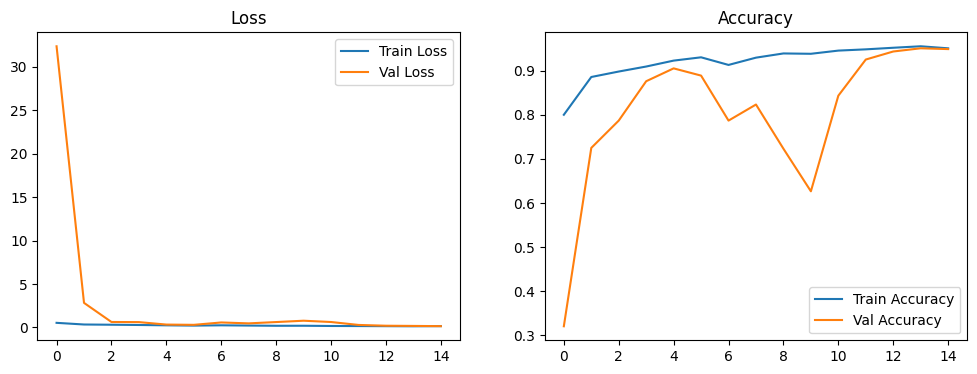

In [68]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate the Model on Test Data**

In [72]:
# Evaluate the Model on Test Data
model.load_weights('best_resnet50v2_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Generate Classification Report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9138 - auc: 0.9853 - loss: 0.2152 - precision: 0.9138 - recall: 0.9138
Test Loss: 0.1501
Test Accuracy: 0.9345
Test Precision: 0.9345
Test Recall: 0.9345
Test AUC: 0.9927
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.88      0.95      0.91        82
         ROP       0.96      0.94      0.95       190

    accuracy                           0.93       275
   macro avg       0.61      0.63      0.62       275
weighted avg       0.93      0.93      0.93       275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Confusion Matrix**


Confusion Matrix:
[[  0   0   3]
 [  0  78   4]
 [  0  11 179]]


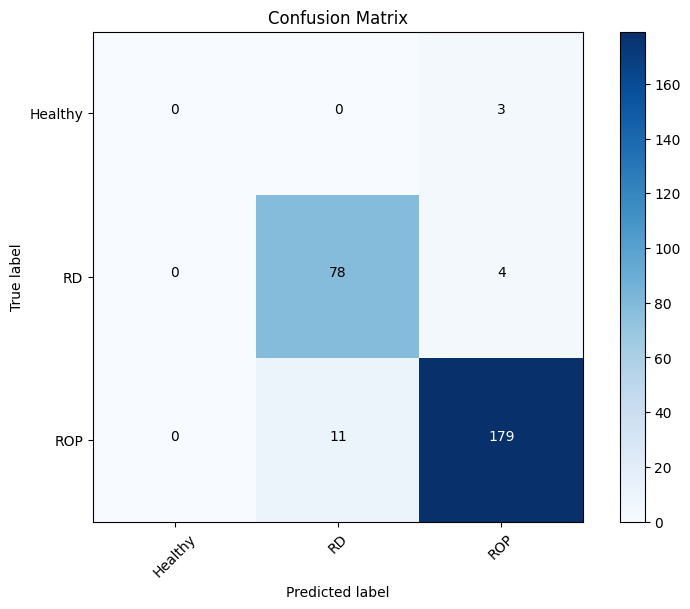

In [73]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [76]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'resnet50v2_rop_model_o.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/resnet50v2_rop_model_o.h5


# **ConvNeXt**

## **Import Libraries and Set Random Seeds**

In [49]:

# Import Libraries and Set Random Seeds
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtBase  # ConvNeXt model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## **Dataset Paths and Parameters**

In [ ]:
# Define dataset paths and parameters
BASE_DIR = '/content/drive/My Drive/AIROP/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15


In [ ]:
# Vessel Segmentation Functions
import cv2
from skimage import morphology, measure

def resize_image(image, size=(512, 512)):
    return cv2.resize(image, size)

def extract_green_channel(image):
    return image[:, :, 1]

def apply_clahe(image, clip_limit=1.5, tile_grid_size=(1, 1)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

def invert_image(image):
    return cv2.bitwise_not(image)

def apply_adaptive_threshold(image, block_size=25, C=6):
    thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    return invert_image(thresholded_image)

def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def morphology_opening(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphology_dilate(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(image, kernel)

def remove_small_objects(image, min_size=500):
    labels = measure.label(image)
    cleaned = morphology.remove_small_objects(labels, min_size=min_size)
    cleaned = (cleaned > 0).astype(np.uint8) * 255
    return cleaned

def vessel_segmentation(image):
    resized_image = resize_image(image)
    green_channel = extract_green_channel(resized_image)
    enhanced_image = apply_clahe(green_channel)
    adaptive_thresh_image = apply_adaptive_threshold(enhanced_image)
    median_filtered_image = apply_median_filter(adaptive_thresh_image)
    opened_image = morphology_opening(median_filtered_image, kernel_size=2)
    dilated_image = morphology_dilate(opened_image, kernel_size=3)
    final_image = remove_small_objects(dilated_image, min_size=100)
    return final_image

def overlay_segmentation(original_image, segmented_image):
    # Resize the segmented image to match the original image's dimensions
    segmented_image_resized = cv2.resize(segmented_image, (original_image.shape[1], original_image.shape[0]))

    # Convert the segmented image to a 3-channel mask
    mask = cv2.cvtColor(segmented_image_resized, cv2.COLOR_GRAY2BGR)

    # Apply a green overlay
    mask = cv2.bitwise_and(mask, np.array([0, 255, 0], dtype=np.uint8))  # Green overlay

    # Overlay the mask on the original image
    overlayed_image = cv2.addWeighted(original_image, 1, mask, 0.5, 0)
    return overlayed_image

# Function to preprocess images with vessel segmentation overlay
def preprocess_images(image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Traverse subdirectories (e.g., Healthy, ROP, RD)
    for class_name in os.listdir(image_dir):
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip if it's not a directory

        # Create corresponding output subdirectory
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        # Process each image in the subdirectory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Unable to read image {image_path}. Skipping.")
                continue  # Skip if the image is not valid

            # Apply vessel segmentation
            segmented_image = vessel_segmentation(original_image)

            # Overlay segmentation on the original image
            overlayed_image = overlay_segmentation(original_image, segmented_image)

            # Resize to the required input size for the model
            overlayed_image = cv2.resize(overlayed_image, (IMG_SIZE, IMG_SIZE))

            # Save the preprocessed image
            output_path = os.path.join(output_class_dir, image_name)
            cv2.imwrite(output_path, overlayed_image)

            # Plot the first image for visualization
            if not hasattr(preprocess_images, 'plot_done'):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(segmented_image, cmap='gray')
                plt.title("Segmented Vessels")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
                plt.title("Overlayed Image")
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                preprocess_images.plot_done = True  # Ensure plotting is done only once

# Preprocess training, validation, and test images
print("Preprocessing training images...")
preprocess_images(TRAIN_DIR, os.path.join(BASE_DIR, 'train_processed'))

print("Preprocessing validation images...")
preprocess_images(VALID_DIR, os.path.join(BASE_DIR, 'valid_processed'))

print("Preprocessing test images...")
preprocess_images(TEST_DIR, os.path.join(BASE_DIR, 'test_processed'))

# Update dataset paths to processed images
TRAIN_DIR_PROCESSED = os.path.join(BASE_DIR, 'train_processed')
VALID_DIR_PROCESSED = os.path.join(BASE_DIR, 'valid_processed')
TEST_DIR_PROCESSED = os.path.join(BASE_DIR, 'test_processed')

## **Data Preprocessing and Augmentation**

In [50]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR_PROCESSED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Function for Building Models**

In [51]:
# Build and Compile the Model
# Load ConvNeXt model
convnext_base = ConvNeXtBase(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    convnext_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,569,539 (334.05 MB)

 Trainable params: 87,569,539 (334.05 MB)

 Non-trainable params: 0 (0.00 B)

## **Train ConvNeXt**

In [52]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_convnext_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.6148 - auc: 0.7912 - loss: 1.2039 - precision: 0.6191 - recall: 0.6103
Epoch 1: val_loss improved from inf to 0.65506, saving model to best_convnext_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.6151 - auc: 0.7915 - loss: 1.2011 - precision: 0.6194 - recall: 0.6106 - val_accuracy: 0.6995 - val_auc: 0.8452 - val_loss: 0.6551 - val_precision: 0.6995 - val_recall: 0.6995
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.6878 - auc: 0.8399 - loss: 0.7191 - precision: 0.6899 - recall: 0.6830
Epoch 2: val_loss did not improve from 0.65506
122/122 ━━━━━━━━━━━━━━━━━━━━ 86s 678ms/step - accuracy: 0.6878 - auc: 0.8400 - loss: 0.7189 - precision: 0.6900 - recall: 0.6831 - val_accuracy: 0.6995 - val_auc: 0.8452 - val_loss: 0.6575 - val_precision: 0.6995 - val_recall: 0.6995
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.6955 - auc: 0.8435 - loss: 0.6906 - precision: 0.6967 - recall

## **Plot Training History**

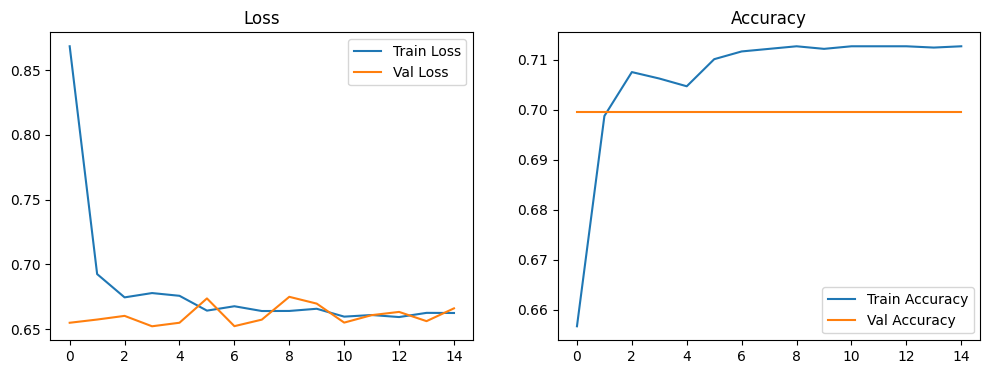

In [53]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Generate Reports And Visualizations**

In [54]:
# Evaluate the Model on Test Data
model.load_weights('best_convnext_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Generate Classification Report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step - accuracy: 0.4147 - auc: 0.6935 - loss: 0.9699 - precision: 0.4147 - recall: 0.4147     
Test Loss: 0.6665
Test Accuracy: 0.6909
Test Precision: 0.6909
Test Recall: 0.6909
Test AUC: 0.8400
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 720ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.00      0.00      0.00        82
         ROP       0.69      1.00      0.82       190

    accuracy                           0.69       275
   macro avg       0.23      0.33      0.27       275
weighted avg       0.48      0.69      0.56       275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Confusion Matrix**


Confusion Matrix:
[[  0   0   3]
 [  0   0  82]
 [  0   0 190]]


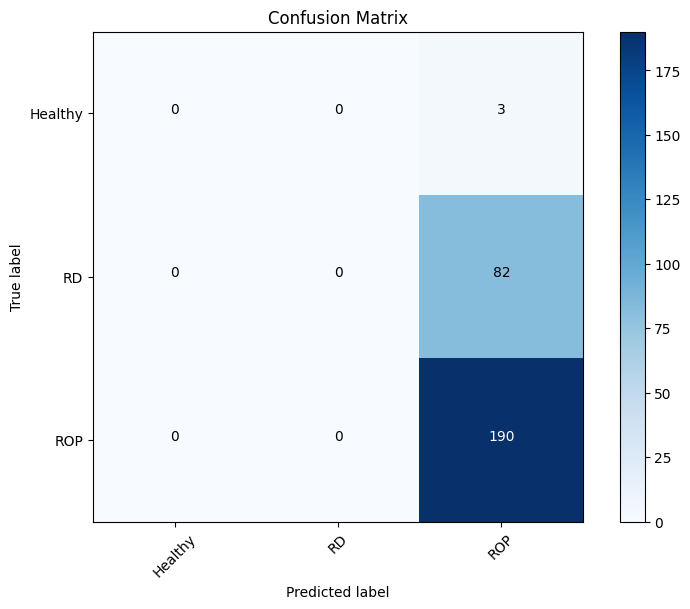

In [57]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## **Save the Model**

In [60]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'convnext_rop_model_o.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/convnext_rop_model_o.h5
